### 預載作圖工具

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

### 參考文獻
- J. Kemp, S. Nishio, R. Satoh, D. Vogt-Lee, and T. Bassan, [Implementation of Quantum Walks on Cycle Graph](https://github.com/desireevl/quantum_walk)

- E. K. Inan1 and M. Abidalrekab, [A Review of Quantum Random Walks and their Algorithmic Applications](https://fangsong.info/teaching/s17_4510_qc/proj_AI_QW.pdf)

## 古典隨機行走實驗

In [2]:
steps=15 # 每次實驗都走 steps=15 步 （翻 15 次硬幣）

In [3]:
def classicalWalk(steps=15, sample=100):
    loclst = []
    
    # sample=100 代表進行 100 次實驗，每次實驗都走 steps=15 步 （翻 15 次硬幣）
    for j in range(sample): 
        currentLocation = 0
        for i in range(steps): 
            # 每走一步都會將翻硬幣的結果 （ np.random.randint(2) 結果為 0或1）轉成 2*0-1=-1 或 2*1-1=1
            # 再加到 currentLocation
            currentLocation+=2*np.random.randint(2)-1
        # 執行完一次實驗，於 loclst 中紀錄 15 次翻硬幣後之位置
        loclst += [currentLocation]

    return (loclst)

(array([0.0034, 0.0129, 0.0422, 0.2453, 0.1968, 0.1968, 0.24  , 0.0458,
        0.0138, 0.003 ]),
 array([-13. , -10.4,  -7.8,  -5.2,  -2.6,   0. ,   2.6,   5.2,   7.8,
         10.4,  13. ]),
 <BarContainer object of 10 artists>)

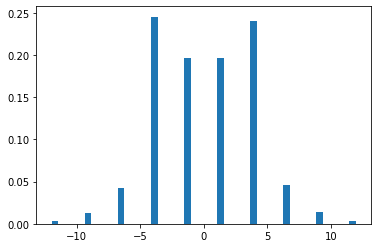

In [4]:
f,ax=plt.subplots()

loclst = classicalWalk(steps=steps, sample=10000)

# 針對 loclst 取 histogram 看統計結果
counts, bins=np.histogram(loclst)
ax.hist(bins[:-1], bins, weights=counts/counts.sum(),
        rwidth=0.2, alpha=1, label=None, color='C0')

這裡我們可以看到古典隨機行走 ```2*np.random.randint(2)-1 ``` 的結果，「大致上」會集中在原點附近。

## 量子隨機行走實驗

在讓我們看看如何在 ```qiskit``` 裡進行量子隨機行走。關於 ```qiskit``` 的作業流程請參考 [Introduction to Qiskit 0.34.2](https://qiskit.org/documentation/intro_tutorial1.html)

底下我們照該網站的 "Workflow Step–by–Step" 小節逐步說明：

### 第一&二步 : Import Packages & Initialize Variables

In [5]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, BasicAer, execute#, IBMQ
from qiskit.tools.visualization import plot_histogram

Co = 1
Re = 5*Co

QrC = QuantumRegister(Co, 'coin')
QrR = QuantumRegister(Re, 'input')
Cr = ClassicalRegister(Re)

backend = BasicAer.get_backend("qasm_simulator")

qc = QuantumCircuit(QrC,QrR,Cr)

### 第三步：Add Gates

現在讓我們照底下電路依序添加量子邏輯閘：

![](https://i.imgur.com/BiyXkte.png)

In [6]:
for i in range(20):
    # superposition (H) -> increase (INC) -> filp control (X) -> decrease (DEC)
    qc.h(QrC[0])
    
    qc.mcx([QrC[0],QrR[0],QrR[1],QrR[2],QrR[3]],QrR[4])
    qc.mcx([QrC[0],QrR[0],QrR[1],QrR[2]],QrR[3])
    qc.mcx([QrC[0],QrR[0],QrR[1]],QrR[2])
    qc.mcx([QrC[0],QrR[0]],QrR[1])
    qc.cx(QrC[0],QrR[0])
    
    qc.x(QrC[0])
    
    qc.cx(QrC[0],QrR[0])
    qc.mcx([QrC[0],QrR[0]],QrR[1])
    qc.mcx([QrC[0],QrR[0],QrR[1]],QrR[2])
    qc.mcx([QrC[0],QrR[0],QrR[1],QrR[2]],QrR[3])
    qc.mcx([QrC[0],QrR[0],QrR[1],QrR[2],QrR[3]],QrR[4])
    qc.x(QrC[0])
    
qc.measure(QrR,Cr)

### 第四步：Visualize the Circuit

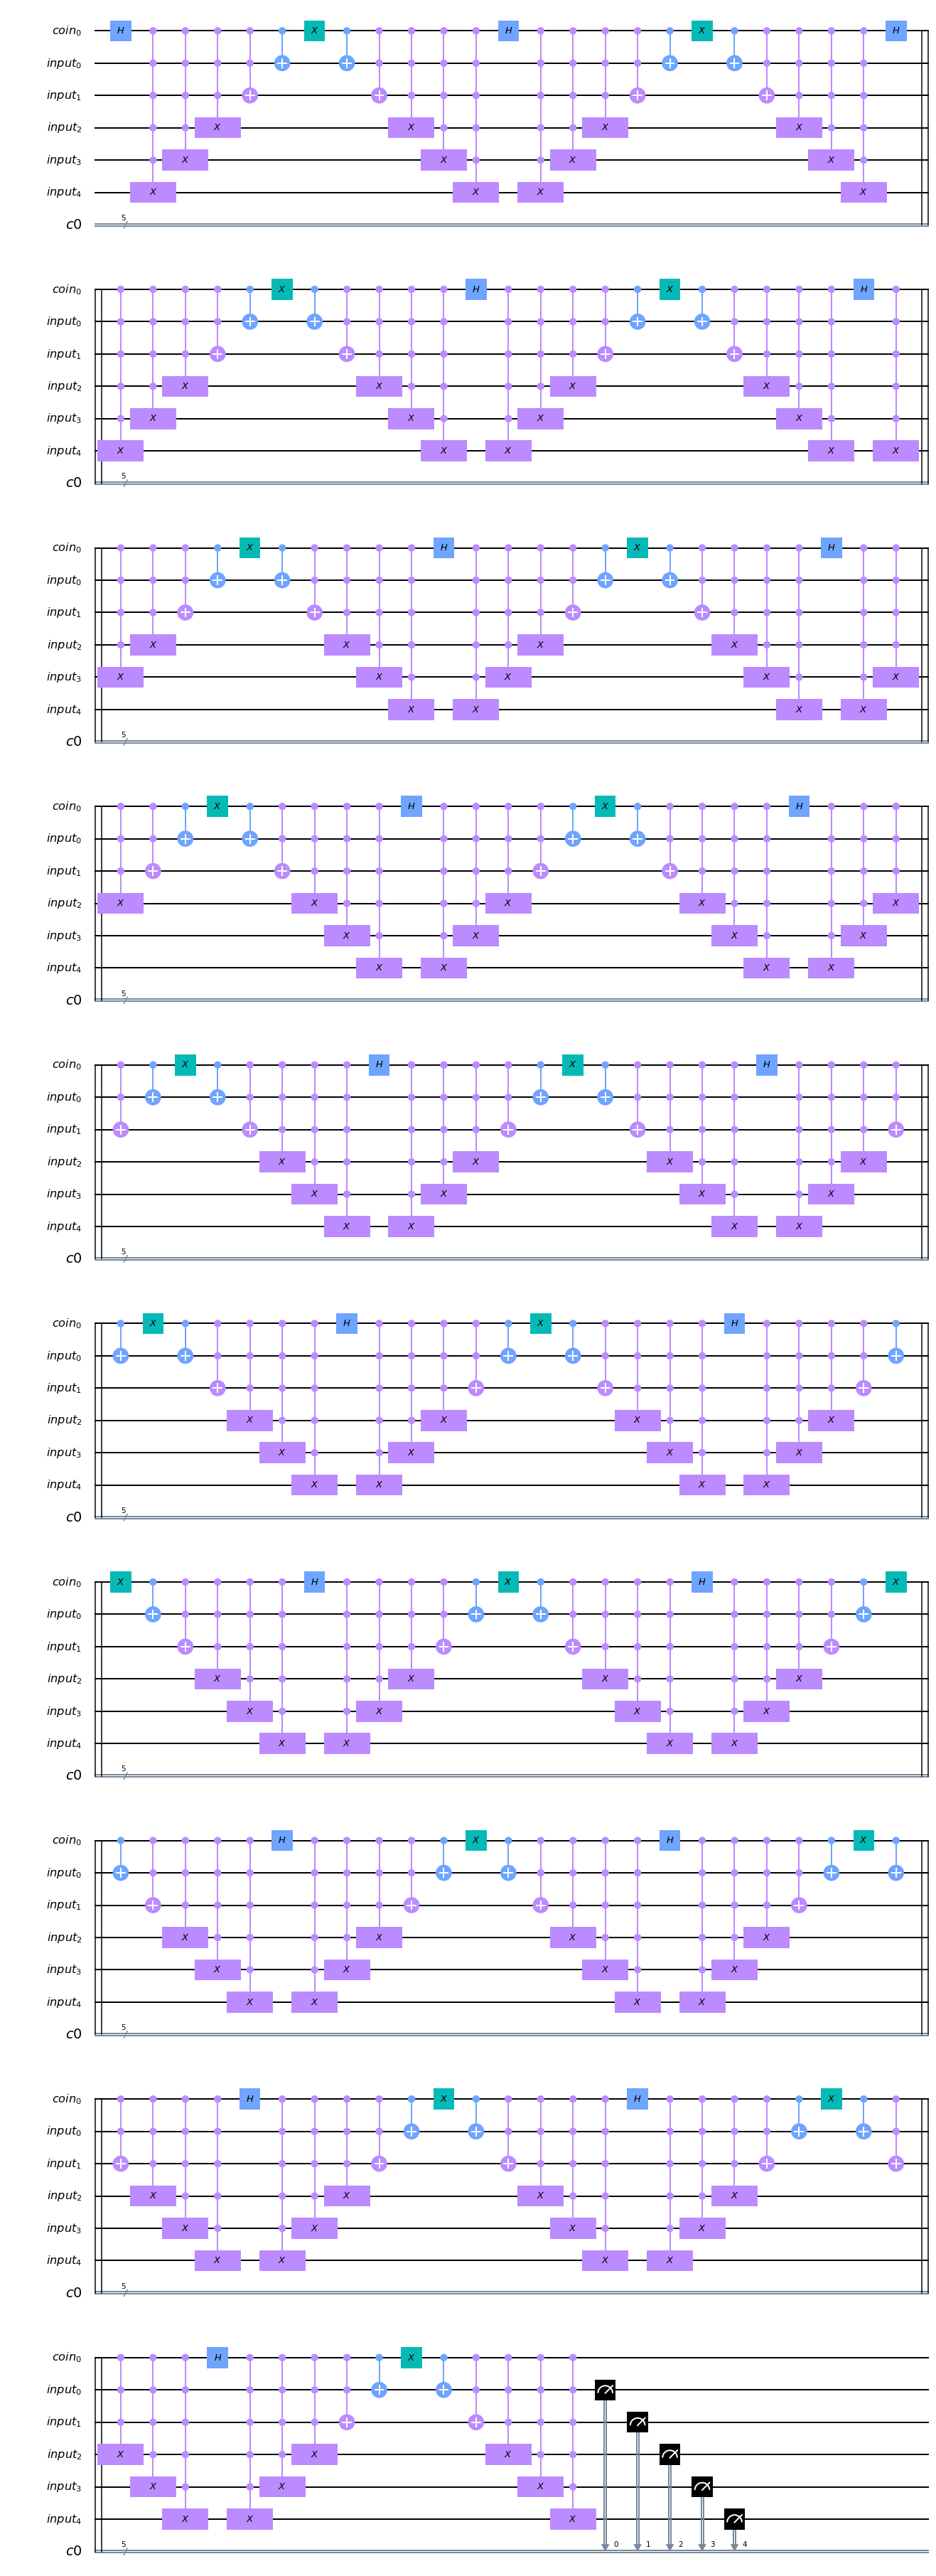

In [7]:
qc.draw('mpl')

### 第五步：Simulate the Experiment

In [8]:
job = execute(qc,backend=backend).result().get_counts()

### 第六步：Visualize the Results

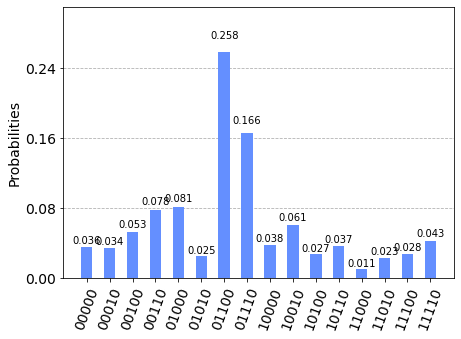

In [9]:
# 將原始的量測結果初步作圖 （注意這裡的 X 軸尚未依行走的順序排列）
display(plot_histogram(job))

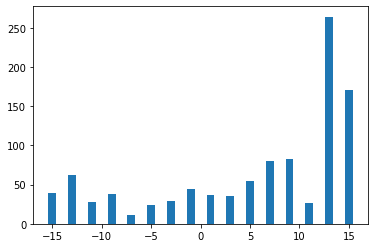

In [10]:
# 將量測結果依行走的順序排列後重新作圖

def jobplot(job, ax, color='C0', Re=Re, alpha=1, label=None):
    xlst,ylst = [],[]
    for i in job:
        
        # qiskit 執行完量子電路後 job 回傳的格式是由 0 與 1 構成的字串如 '00010'，這邊
        val = int(i,2)
        if val>=2**(Re-1) :
            xlst += [(val-2**Re+0)*1+1]
        else:
            xlst += [(val+0)*1+1]
        ylst +=[job[i]] 
    ax.bar(xlst,ylst,alpha=alpha,color=color,label=label)
    
f,ax=plt.subplots()
jobplot(job,ax)

## 比較不同的隨機行走結果：古典邏輯 vs 量子邏輯電路

### 我們的模擬結果

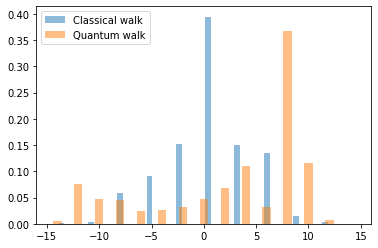

In [11]:
f,ax=plt.subplots()


################ CLASSICAL RANDOM WALK ################

loclst = classicalWalk(steps=steps, sample=10000)
counts, bins=np.histogram(loclst)
ax.hist(bins[:-1], bins, weights=counts/counts.sum(),
        rwidth=0.2, alpha=0.5, label='Classical walk', color='C0')


################  QUANTUM  RANDOM WALK ################

qc = QuantumCircuit(QrC,QrR,Cr)
for i in range(steps):
    qc.h(QrC[0])
    qc.mcx([QrC[0],QrR[0],QrR[1],QrR[2],QrR[3]],QrR[4])
    qc.mcx([QrC[0],QrR[0],QrR[1],QrR[2]],QrR[3])
    qc.mcx([QrC[0],QrR[0],QrR[1]],QrR[2])
    qc.mcx([QrC[0],QrR[0]],QrR[1])
    qc.cx(QrC[0],QrR[0])
    qc.x(QrC[0])
    qc.cx(QrC[0],QrR[0])
    qc.mcx([QrC[0],QrR[0]],QrR[1])
    qc.mcx([QrC[0],QrR[0],QrR[1]],QrR[2])
    qc.mcx([QrC[0],QrR[0],QrR[1],QrR[2]],QrR[3])
    qc.mcx([QrC[0],QrR[0],QrR[1],QrR[2],QrR[3]],QrR[4])
    qc.x(QrC[0])
qc.measure(QrR,Cr)

job = execute(qc,backend=backend).result().get_counts()

def jobNorm(job):
    total = 0
    for i in job:
        total += job[i]
    lst = [job[i]/(total) for i in job]

    jod = {}
    for i,v in enumerate(job):
        jod[v] = lst[i]
    return [job, jod]

xlst,ylst = [],[]
for i in jobNorm(job)[1]:
    val = int(i,2)
    if val>=2**(Re-1)+2 :
        xlst += [(val-2**Re+1)-2]
    else:
        xlst += [(val+1)-2]
    ylst +=[jobNorm(job)[1][i]]  
ax.bar(xlst,ylst,color='C1',alpha=0.5,label = 'Quantum walk')

#######################################################

ax.set_xlim(-16,16)
ax.legend()

### 對照維基百科[Quantum Walk](https://en.wikipedia.org/wiki/Quantum_walk)辭條中的結果
![](https://upload.wikimedia.org/wikipedia/commons/c/cf/One_dimensional_quantum_random_walk.svg)